# Covid Zip Code Analysis (EDA)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
df = pd.read_pickle(r'complete_df.pickle')

In [45]:
df.head()

,ZCTA,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,2weeksprior,testpercent,posRate,percent_change_pos_rate
0,60601,14675.0,34.9,103243.0,1.655573,0.086814,0.055741,0.741670,0.239387,0.035434,0.029972,0.040341,0.083543,0.145963,0.002052,0.037657,0.077888,0.054243,0.016586
1,60602,1244.0,30.6,157125.0,2.066445,0.065113,0.037781,0.681672,0.117363,0.047428,0.008842,0.000804,0.126206,0.245981,0.004248,0.065421,0.083601,0.048077,-0.017344
2,60603,1174.0,28.9,151765.0,2.081560,0.097956,0.032368,0.634583,0.160136,0.000000,0.069847,0.055366,0.080068,0.231687,0.005119,0.034483,0.061329,0.041667,0.007184
3,60604,782.0,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123,0.026667,0.084399,0.090909,0.064242
4,60605,27519.0,33.9,111164.0,1.984782,0.058432,0.171772,0.612050,0.103601,0.013700,0.026408,0.025146,0.101821,0.252516,0.008169,0.033480,0.086231,0.063211,0.029731


In [72]:
testing_rate = df.testpercent
positivity_rate = df.posRate
features = df.iloc[:,2:-4]

In [47]:
features.head()

,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist
0,34.9,103243.0,1.655573,0.086814,0.055741,0.741670,0.239387,0.035434,0.029972,0.040341,0.083543,0.145963,0.002052
1,30.6,157125.0,2.066445,0.065113,0.037781,0.681672,0.117363,0.047428,0.008842,0.000804,0.126206,0.245981,0.004248
2,28.9,151765.0,2.081560,0.097956,0.032368,0.634583,0.160136,0.000000,0.069847,0.055366,0.080068,0.231687,0.005119
3,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123
4,33.9,111164.0,1.984782,0.058432,0.171772,0.612050,0.103601,0.013700,0.026408,0.025146,0.101821,0.252516,0.008169


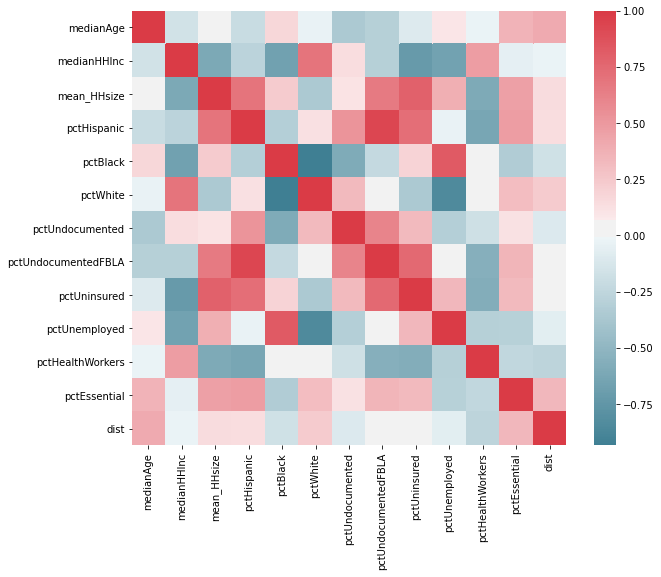

In [29]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In the above correlation matrix, we can see that the following are highly correlated with one another:
- Percent White & Percent Black (-)
- Percent White & Percent Unemployed (-)
- Percent Hispanic & Percent Undocumented FBLA (Foreign Born Latin America) (+)
- Percent Black & Percent Unemployed (+)
- Percent Uninsured & Mean HH Size (+)
- Median Income & Percent Unisured (-)

In the below regression analyses, I will run each regression using all variables, first, and then remove those that are not significant at the 10 percent confidence level (p>0.1).

In [58]:
# Calculating correlation between each variable and each target variable
posCorr = []
for each in features.columns:
    posCorr.append({'variable': each, 'posRate': df.posRate.corr(df[each])})

corr_df = pd.DataFrame(posCorr)

corr_df['testing'] = [df.testpercent.corr(df[each]) for each in corr_df.variable]


In [59]:
corr_df

,variable,posRate,testing
0,medianAge,0.121379,-0.333549
1,medianHHInc,-0.280850,0.410700
2,mean_HHsize,0.718531,-0.549070
3,pctHispanic,0.775902,-0.297303
4,pctBlack,-0.121945,-0.287392
5,pctWhite,-0.002157,0.338152
6,pctUndocumented,0.279795,-0.004870
7,pctUndocumentedFBLA,0.677603,-0.290306
8,pctUninsured,0.552382,-0.527761
9,pctUnemployed,0.160296,-0.420695


In [49]:
# Checking for multicollinearity - removing vars that are highly correlated with one another (r>.9). Removing var
# that has weaker correlation with target(s)
features.corr()

,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist
medianAge,1.000000,-0.158533,0.030385,-0.206000,0.170765,-0.030374,-0.359357,-0.299637,-0.093589,0.096852,-0.021349,0.362413,0.408701
medianHHInc,-0.158533,1.000000,-0.605542,-0.269620,-0.662372,0.695532,0.141893,-0.302896,-0.721250,-0.658665,0.474575,-0.057018,-0.021039
mean_HHsize,0.030385,-0.605542,1.000000,0.697552,0.231909,-0.358945,0.113303,0.665735,0.792620,0.385127,-0.600068,0.459942,0.153446
pctHispanic,-0.206000,-0.269620,0.697552,1.000000,-0.312297,0.124771,0.529451,0.937891,0.724414,-0.029607,-0.628410,0.476823,0.141983
pctBlack,0.170765,-0.662372,0.231909,-0.312297,1.000000,-0.934254,-0.589178,-0.231509,0.194170,0.828228,-0.004182,-0.326467,-0.163979
pctWhite,-0.030374,0.695532,-0.358945,0.124771,-0.934254,1.000000,0.320554,0.012955,-0.355809,-0.845012,0.053311,0.311977,0.233599
pctUndocumented,-0.359357,0.141893,0.113303,0.529451,-0.589178,0.320554,1.000000,0.609566,0.325229,-0.312535,-0.171668,0.120374,-0.102437
pctUndocumentedFBLA,-0.299637,-0.302896,0.665735,0.937891,-0.231509,0.012955,0.609566,1.000000,0.756019,0.026978,-0.551217,0.354265,0.000706
pctUninsured,-0.093589,-0.721250,0.792620,0.724414,0.194170,-0.355809,0.325229,0.756019,1.000000,0.341004,-0.571398,0.321028,-0.002298
pctUnemployed,0.096852,-0.658665,0.385127,-0.029607,0.828228,-0.845012,-0.312535,0.026978,0.341004,1.000000,-0.301502,-0.295009,-0.069599


In the correlation dataframe above, I will remove variables from the regression that have a correlation that is greater than 0.9. These variables include:
- pctUndocumentedFBLA
- pctWhite


In [73]:
features.drop(columns=['pctUndocumentedFBLA', 'pctWhite'], inplace=True)

## Exploring the relationship between each feature and positivity rates in a Zip Code

In [74]:
# Run an OLS regression to determine which variables are most correlated with ridership
import statsmodels.api as sm

X = sm.add_constant(features)
y = positivity_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                posRate   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     18.01
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           7.69e-13
Time:                        21:23:25   Log-Likelihood:                 150.70
No. Observations:                  56   AIC:                            -277.4
Df Residuals:                      44   BIC:                            -253.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0677      0.043  

## Robust Linear Model

In [77]:
import statsmodels.api as sm

X = sm.add_constant(features)

# Fit model and print summary
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())

rlm_results = rlm_model.fit()

print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                posRate   No. Observations:                   56
Model:                            RLM   Df Residuals:                       44
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 12 Nov 2020                                         
Time:                        22:02:19                                         
No. Iterations:                    42                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0486      0.041  

### Positivity Rates Analysis
The above output tables show that only five features in the dataset are robust - **Mean Household Size, Percent Hispanic, Percent Uninsured, Percent Healthcare Workers, and Percent Essential Workers**. That is to say that these five features are significantly correlated with a ZIP code's 2-week average positivity rate controlling for the other variables.

#### Interpretation:
- A one-person increase in the **mean household size** of a zipcode is estimated to increase the area's positivity rate by 0.0017 percentage points. 
- A one-percentage-point increase in **percent Hispanic** is expected to increase an area's positivity rate by 0.124 percentage points. 
- A one-percentage-point increase in an area's percentage of **uninsured individuals** is expected to decrease an area's positivity rate by 0.309 percentage points. 
- A one-percentage point increase in an area's **composition of healthcare workers** is expected to result in a 0.696 percentage-point decrease in COVID-19 positivity rates.
- A one percentage-point increase in a zip code's **percentage of essential workers** is estimated to be associated with a 0.237 percentage-point increase in Covid positivity rates.

## Exploring the relationship between each feature and testing

In [78]:
# Run an OLS regression to determine which variables are most correlated with ridership

X = sm.add_constant(features)
y = testing_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            testpercent   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     5.249
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           3.17e-05
Time:                        22:20:02   Log-Likelihood:                 152.61
No. Observations:                  56   AIC:                            -281.2
Df Residuals:                      44   BIC:                            -256.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2773      0.042  

## Robust Linear Model

In [79]:
# re-running the regression with only significant features (p<0.05)
X = sm.add_constant(features)
y = testing_rate

# Fit model and print summary
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())

rlm_results = rlm_model.fit()

print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            testpercent   No. Observations:                   56
Model:                            RLM   Df Residuals:                       44
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 12 Nov 2020                                         
Time:                        22:27:18                                         
No. Iterations:                    50                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2239      0.022  

### Testing Rates Analysis
The above output tables show that only one feature in the dataset is robust - **Median Age, Median Household Income, Mean Household Size, Percent Uninsured, and Percent Unemployed**. That is to say that these two features are significantly negatively correlated with a zip code's percentage of residents who get tested.

#### Interpretation:
- A one-year increase in a zip code's **median age** is associated with an expected 0.0020 percentage-point decrease in an area's testing rate. This is likely due to the high rates of testing in college neighborhoods such as Hyde Park, West Loop, Lincoln Park and Rogers Park.
- A 10,000 dollar increase in an area's **median household income** is expected to decrease the area's testing rate by 0.003 percentage points, on average.
- A one-person increase in the **mean household size** of a zip code is expected to decrease the testing rate by 0.013 percentage points, on average.  
- A one-percentage-point increase in an area's **percentage of uninsured individuals** is associated with an expected 0.0274 percentage-point decrease in the area's positivity rates. This could imply that individuals who are uninsured may not be aware that testing is readily available at no cost.
- A one-percentage-point increase in an area's **percentage of unemployed individuals** is expected to decrease the area's testing rate by 0.244 percentage points.


## Scatter plots

In [81]:
# Defining color palette
colors =["#ea8171","#155F83", "#8F3931", "#8A9045", "#D5802B", "#350E20", "#58593F", "#880d1e", '#c8674c',
        '#a2755e']

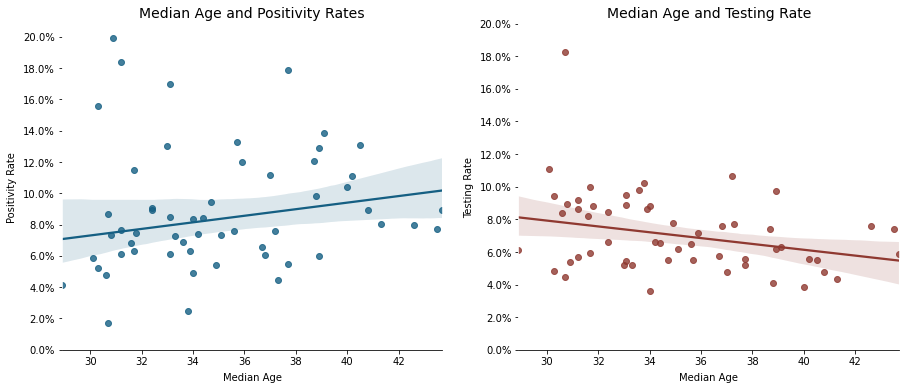

In [159]:
import seaborn as sns
import matplotlib.ticker as mtick

# Creating subplots and defining x and y's
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.patch.set_facecolor('white')
x = df.medianAge
y1 = positivity_rate
y2 = testing_rate

# Creating ax1
sns.regplot(x, y1, robust=True, color = colors[1], ax=ax1)
ax1.set_title('Median Age and Positivity Rates', fontsize=14)
ax1.set_xlabel('Median Age', labelpad=6.0)
ax1.set_yticks(np.arange(0,.22,.02))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
ax1.set_ylabel('Positivity Rate', labelpad=6.0)
if x.mean() <= 1:
    ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
    
# Creating ax2
sns.regplot(x, y2, robust=True, color = colors[2], ax=ax2)
ax2.set_title('Median Age and Testing Rate', fontsize=14)
ax2.set_xlabel('Median Age', labelpad = 6.0)
ax2.set_yticks(np.arange(0,.22,.02))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
ax2.set_ylabel('Testing Rate', labelpad=6.0)
if x.mean() <= 1:
    ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

# Removing spines from all sides but bottom - ax1
spine_position = ['top', 'left', 'right']
for spine in spine_position:    
    ax1.spines[spine].set_color('white')

# Removing spines from all sides but bottom - ax2
spine_position = ['top', 'left', 'right']
for spine in spine_position:    
    ax2.spines[spine].set_color('white')

plt.show()

In [160]:
from scipy import stats
# Creating a table with correlation coefficients and p-values (for presentation)
corrs_pvals = []
corrs_pvals.append({'var': 'Median Age', 'posRate_r': round(stats.pearsonr(x, y1)[0], 3), 
                   'posRate_p': round(stats.pearsonr(x, y1)[1], 3), 'testing_r': round(stats.pearsonr(x, y2)[0], 3),
                   'testing_p': round(stats.pearsonr(x, y2)[1], 3)})

In [161]:
pd.DataFrame(corrs_pvals)

,var,posRate_r,posRate_p,testing_r,testing_p
0,Median Age,0.121,0.373,-0.334,0.012


In [162]:
# Turn the above code into a function for the rest of the variables.

def make_scatter(x, var_name):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.patch.set_facecolor('white')
    y1 = positivity_rate
    y2 = testing_rate

    sns.regplot(x, y1, robust=True, color = colors[1], ax=ax1)
    ax1.set_title(var_name+' and Positivity Rates', fontsize=14)
    ax1.set_xlabel(var_name, labelpad=6.0)
    ax1.set_yticks(np.arange(0,.22,.02))
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
    ax1.set_ylabel('Positivity Rate', labelpad=6.0)
    if x.mean() <= 1:
        ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

    sns.regplot(x, y2, robust=True, color = colors[2], ax=ax2)
    ax2.set_title(var_name+' and Testing Rate', fontsize=14)
    ax2.set_xlabel(var_name, labelpad = 6.0)
    ax2.set_yticks(np.arange(0,.22,.02))
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
    ax2.set_ylabel('Testing Rate', labelpad=6.0)
    if x.mean() <= 1:
        ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))


    spine_position = ['top', 'left', 'right']
    for spine in spine_position:    
        ax1.spines[spine].set_color('white')

    spine_position = ['top', 'left', 'right']
    for spine in spine_position:    
        ax2.spines[spine].set_color('white')
    
    corrs_pvals.append({'var': var_name, 'posRate_r': round(stats.pearsonr(x, y1)[0], 3), 
                   'posRate_p': round(stats.pearsonr(x, y1)[1], 3), 'testing_r': round(stats.pearsonr(x, y2)[0], 3),
                   'testing_p': round(stats.pearsonr(x, y2)[1], 3)})

    plt.show()

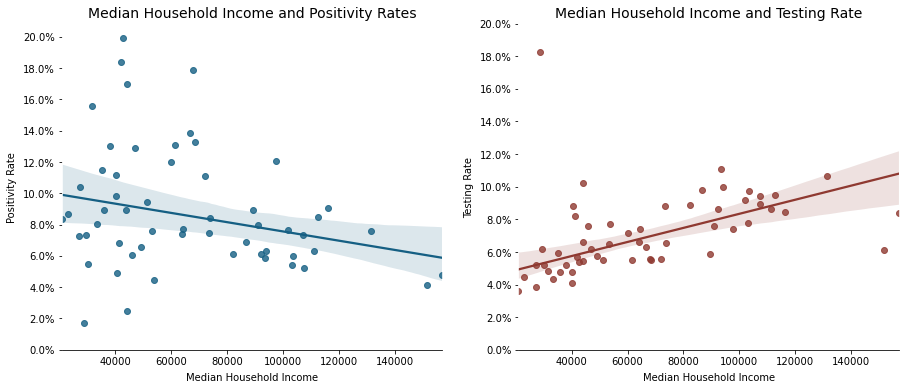

In [163]:
make_scatter(x = df.medianHHInc, var_name = 'Median Household Income' )

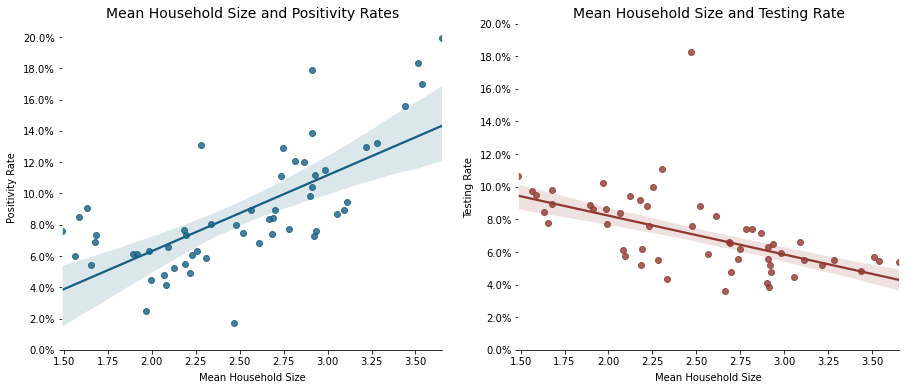

In [164]:
make_scatter(x = df.mean_HHsize, var_name = 'Mean Household Size' )

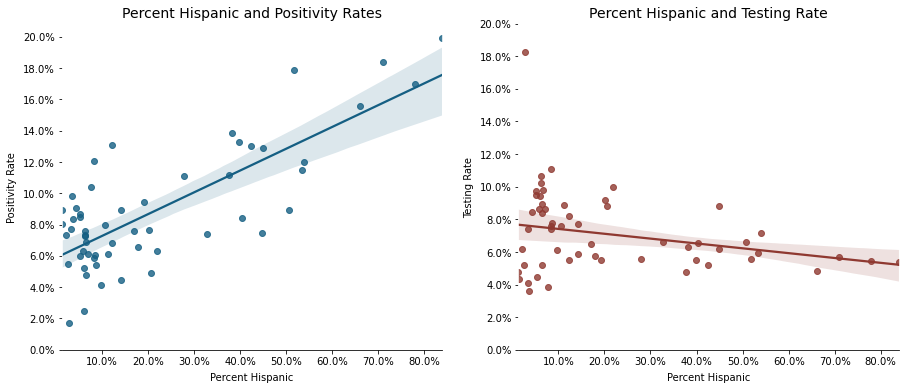

In [165]:
make_scatter(x = df.pctHispanic, var_name = 'Percent Hispanic' )

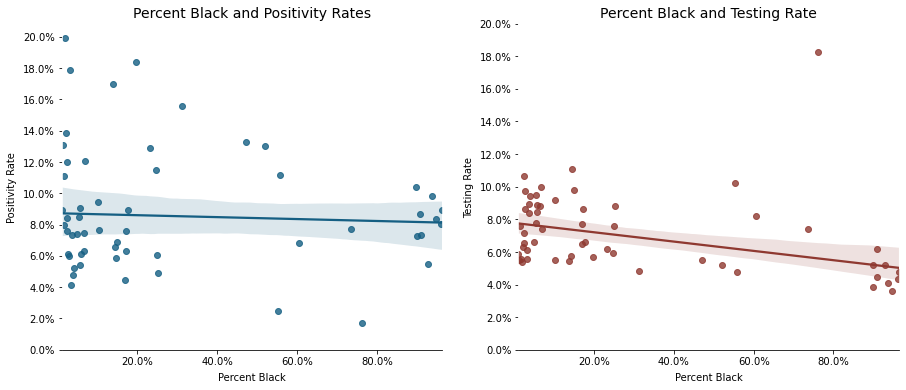

In [166]:
make_scatter(x = df.pctBlack, var_name = 'Percent Black' )

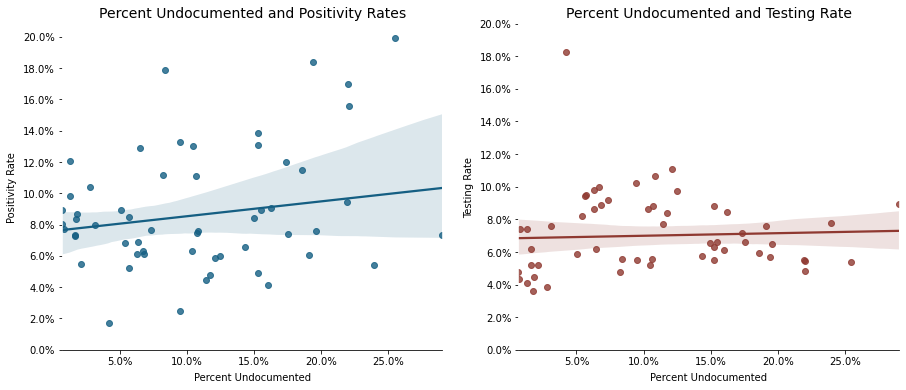

In [167]:
make_scatter(x = df.pctUndocumented, var_name = 'Percent Undocumented' )

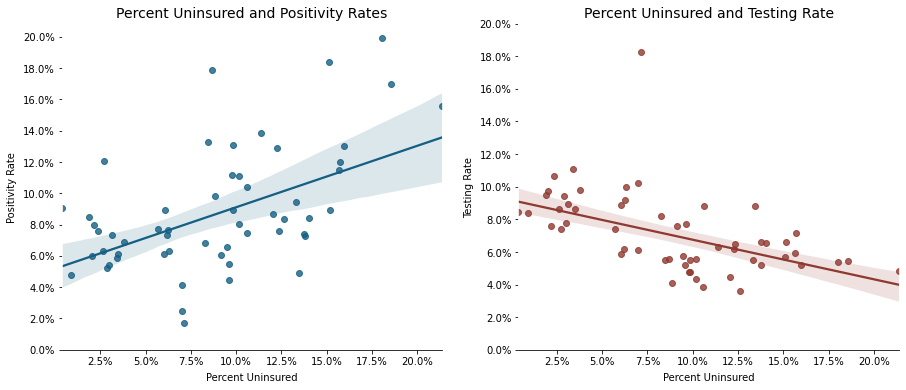

In [168]:
make_scatter(x = df.pctUninsured, var_name = 'Percent Uninsured' )

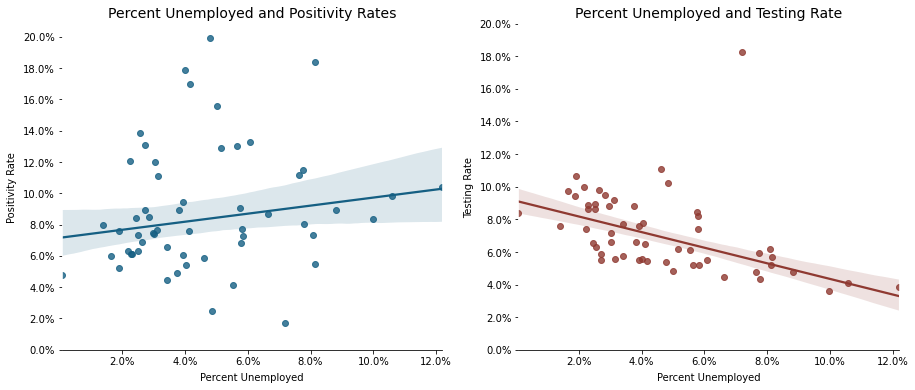

In [169]:
make_scatter(x = df.pctUnemployed, var_name = 'Percent Unemployed' )

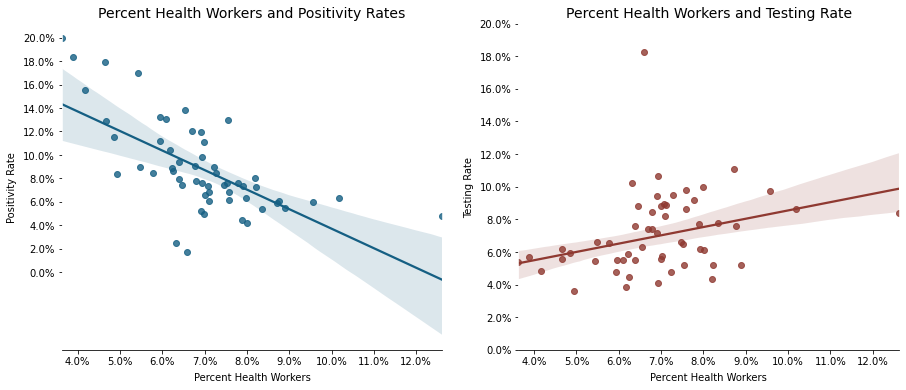

In [170]:
make_scatter(x = df.pctHealthWorkers, var_name = 'Percent Health Workers' )

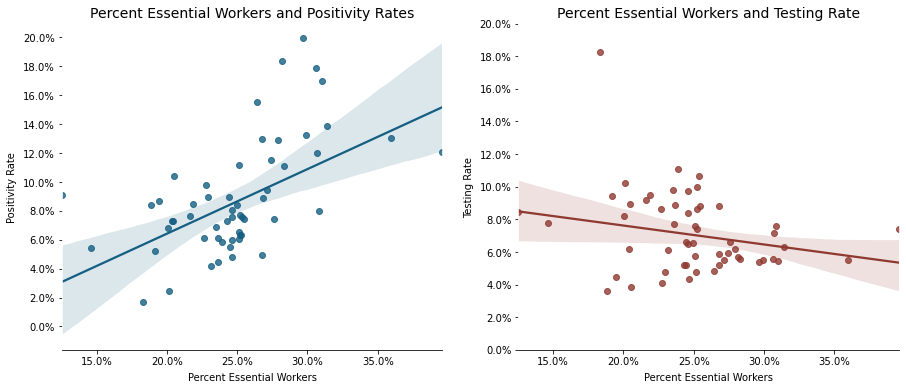

In [171]:
make_scatter(x = df.pctEssential, var_name = 'Percent Essential Workers' )

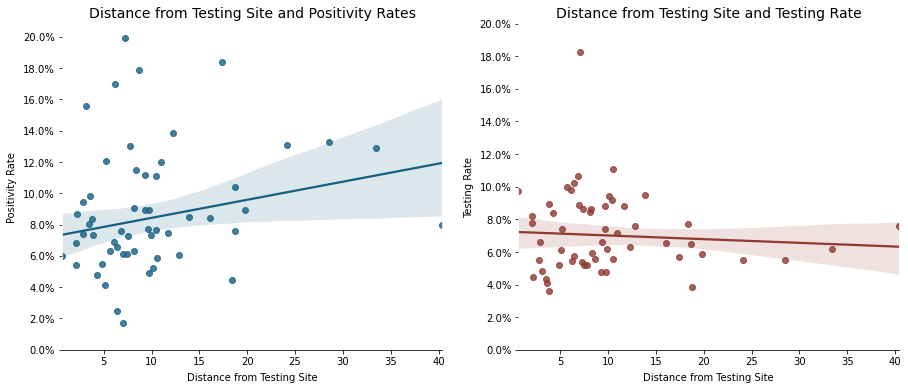

In [172]:
make_scatter(x = df.dist*1000, var_name = 'Distance from Testing Site' )

In [175]:
pd.DataFrame(corrs_pvals)

,var,posRate_r,posRate_p,testing_r,testing_p
0,Median Age,0.121,0.373,-0.334,0.012
1,Median Household Income,-0.281,0.036,0.411,0.002
2,Mean Household Size,0.719,0.000,-0.549,0.000
3,Percent Hispanic,0.776,0.000,-0.297,0.026
4,Percent Black,-0.122,0.371,-0.287,0.032
5,Percent Undocumented,0.280,0.037,-0.005,0.972
6,Percent Uninsured,0.552,0.000,-0.528,0.000
7,Percent Unemployed,0.160,0.238,-0.421,0.001
8,Percent Health Workers,-0.664,0.000,0.306,0.022
9,Percent Essential Workers,0.571,0.000,-0.277,0.038
